In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster as skc
import matplotlib.colors as clrs

## Clustering

Clustering is a fundamental **unsupervised** machine learning task that aims to discover hidden patterns in data. The core principle of clustering revolves around two key concepts: **intra-cluster similarity** (objects within the same cluster should be similar) and **inter-cluster dissimilarity** (objects from different clusters should be different). This balance creates meaningful groupings that can reveal insights about the data structure.

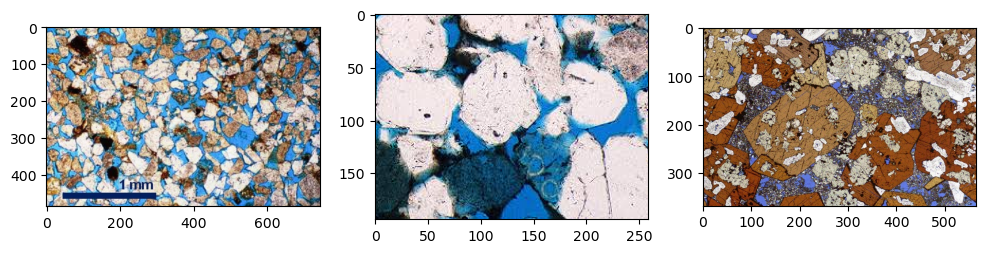

In [2]:
files = ['section1.jpg', 'section2.jpg', 'section3.jpg']
imgs = [plt.imread(file) for file in files]
n_imgs = len(imgs)
fig,axs = plt.subplots(1,n_imgs,figsize=(12,3))
for ax,img in zip(axs,imgs):
    ax.imshow(img)
    

## Feature space

The $R$, $G$ and $B$ values of each pixel can be considered features in a 3D space. Pixels with similar characteristics (*features*, colors) will be close by, while those with significantly different colors will be far apart.

It is our hope that points will *cluster* around different regions in feature space, and identifying these *clusters* can give us insight into the structure of the dataset.

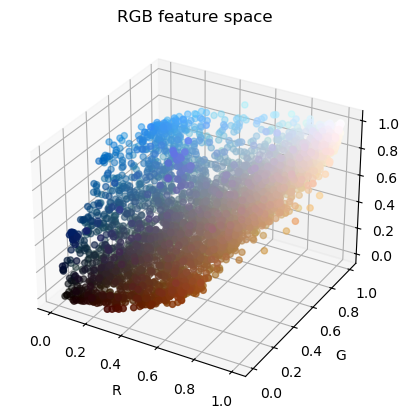

In [3]:

X = np.vstack([img.reshape(-1,3) for img in imgs])/255  # Feature matrix. One example per line, one feature per column

ax = plt.axes(projection='3d')
sub = 150 # subsampling, for speed
ax.scatter(*X[::sub,:].T,c=X[::sub,:])
ax.set_xlabel('R'); ax.set_ylabel('G'); ax.set_zlabel('B')
ax.set_title('RGB feature space')
plt.show()

## K-Means Algorithm

### Mathematical Foundation

K-Means, developed by Stuart Lloyd in 1957, belongs to the clustering family and aims to partition a dataset into **$K$ clusters** where $K$ is a hyperparameter (that is, a parameter that is not optimized by the K-Means algorithm). The algorithm's name reflects its core strategy: finding $K$ centroids (centers) and assigning each data point to the nearest centroid, with each cluster represented by the **mean** of its constituent points.

The algorithm seeks to minimize the **Within-Cluster Sum of Squares (WCSS)**, also known as **inertia**:

$$
WCSS = \sum_{j=1}^K \sum_{i \in C_j} \left\lVert\vec{x}_i-\vec{\mu}_j \right\rVert^2
$$

where $j$ is an index that runs over each of the $K$ clusters, the $i$ sum runs only over the points assigned to the cluster $C_j$ and $\vec{\mu}_j$ is the *centroid* of the cluster:

$$
\vec{\mu}_j = \frac{1}{\left\lvert C_j \right\rvert} \sum_{i \in C_j} \vec{x}_i
$$

where $\left\lvert C_j \right\rvert$ is the number of points in set $C_j$, its *cardinality*.

### Algorithm Steps

The naïve K-Means algorithm (also called Lloyd's algorithm) follows an iterative process with four main steps in order to obtain its partitioning:

**Initialization**: involves choosing $K$ points as initial centroids. While random selection is simple, more sophisticated methods like K-Means++ can lead to better results by choosing centroids that are far from each other.

**Assignment Step**: assigns each data point to the cluster whose centroid is closest:
$C_j = \{ \vec{x}: \left\lVert \vec{x} - \vec{\mu}_j \right\rVert^2 \leq \left\lVert \vec{x} - \vec{\mu}_i \right\rVert^2 \quad \forall i, 1 \leq i \leq K \}$

**Update Step**: recalculates centroids as the mean of points assigned to each cluster:
$\displaystyle \vec{\mu}_j = \frac{1}{\left\lvert C_j \right\rvert} \sum_{i \in C_j} \vec{x}_i$

**Convergence Check**: determines whether to continue iterating. The algorithm stops when centroids don't move significantly, the objective function doesn't improve meaningfully, or a maximum number of iterations is reached.

### Scikit-Learn implementation

A user friendly implementation is available via `skc.KMeans`:

In [4]:
n_clusters = 4 # K, the number of clusters
KM = skc.KMeans(n_clusters=n_clusters) # instantiating the clustering object
KM.fit(X) # training

KMeans(n_clusters=4)

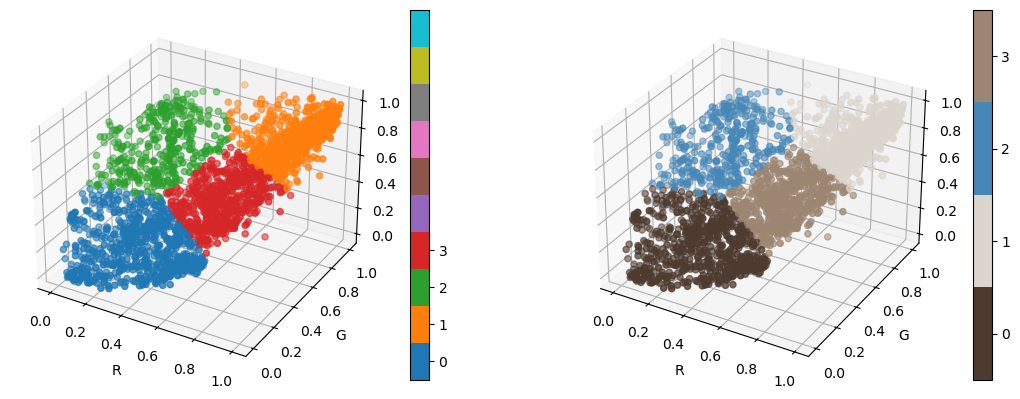

In [5]:
y = KM.predict(X) # the cluster assignment of each data point

# Creating a colormap based on the color of each centroid
custom_cmap = clrs.LinearSegmentedColormap.from_list("custom_colormap", KM.cluster_centers_,n_clusters)

fig = plt.figure(figsize=(12,4))
axs = [fig.add_subplot(1,2,i+1,projection='3d') for i in range(2)]
sub = 250 # subsampling, for speed

# Scatter plot with "random" colors for each cluster 
CS = axs[0].scatter(*X[::sub,:].T,c=y[::sub],cmap='tab10',vmin=-0.5,vmax=9.5)
cbar = plt.colorbar(CS,ax=axs[0])
cbar.set_ticks(range(n_clusters))

# Scatter plot with "centroid" colormap
CS = axs[1].scatter(*X[::sub,:].T,c=y[::sub],cmap=custom_cmap,vmin=-0.5,vmax=n_clusters-0.5)
cbar = plt.colorbar(CS,ax=axs[1])
cbar.set_ticks(range(n_clusters))

for ax in axs:
    ax.set_xlabel('R'); ax.set_ylabel('G'); ax.set_zlabel('B')
plt.tight_layout()

### Theoretical Properties

K-Means has several important theoretical guarantees. The algorithm **always converges** to a local minimum because the objective function decreases monotonically at each iteration. Convergence usually occurs within a few iterations, making the algorithm computationally efficient for typical datasets.

The **computational complexity** is $O(n \times k \times i \times d)$, where $n$ is the number of data points, $k$ is the number of clusters, $i$ is the number of iterations, and $d$ is the number of dimensions. This linear complexity in the number of points makes K-Means scalable to large datasets.

### Strengths and Limitations

K-Means offers several advantages that explain its popularity. The algorithm is **simple and intuitive**, making it easy to understand and implement. It's **computationally efficient** and scales well to large datasets. 

However, K-Means has significant limitations. It requires **specifying $K$ beforehand**, which can be challenging without domain knowledge. The algorithm is **sensitive to initialization**, potentially converging to suboptimal local minima with different starting points. K-Means **assumes spherical clusters** of similar sizes, making it unsuitable for elongated or irregularly shaped clusters. The algorithm is also **sensitive to outliers** since a single extreme point can significantly shift a centroid, and it struggles with **clusters of very different densities or sizes**.

While the the algorithm produces cluster assignments for each point, it does **not** provide the physical (geological) significance of each cluster. It is up to the **domain expert** to interpret the meaning of each cluster and evaluate if the results are meaningful and useful to the problem at hand.

---

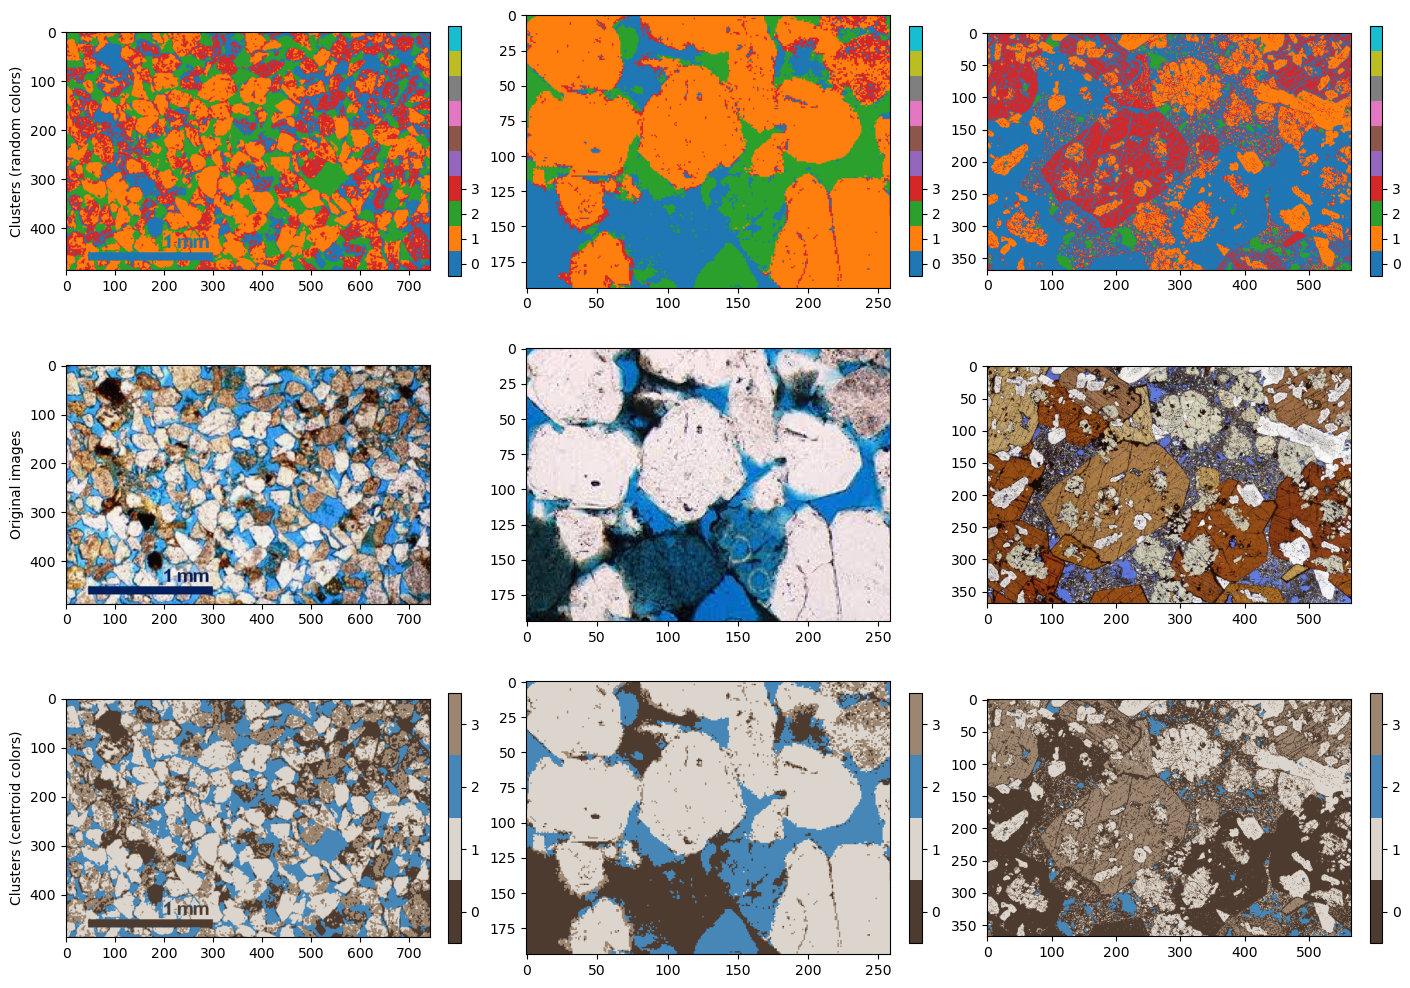

In [10]:
imgs_y = []
i = 0
for img in imgs: # unpacking assignments back into the original img shapes  
    shape = img.shape
    npoints = shape[0]*shape[1]
    imgs_y.append(y[i:i+npoints].reshape(shape[:-1]))
    i += npoints
fig,axs = plt.subplots(3,n_imgs,figsize=(14,10), constrained_layout=True)
for i,(img,img_y) in enumerate(zip(imgs,imgs_y)):
    CS = axs[0,i].imshow(img_y,cmap='tab10',vmin=-0.5,vmax=9.5)
    cbar = plt.colorbar(CS,ax=axs[0,i], shrink=0.8)
    cbar.set_ticks(range(n_clusters))
    axs[1,i].imshow(img)
    CS = axs[2,i].imshow(img_y,cmap=custom_cmap,vmin=-0.5,vmax=n_clusters-0.5)
    cbar = plt.colorbar(CS,ax=axs[2,i], shrink=0.8)
    cbar.set_ticks(range(n_clusters))
axs[0,0].set_ylabel('Clusters (random colors)')
axs[1,0].set_ylabel('Original images')
axs[2,0].set_ylabel('Clusters (centroid colors)')
plt.show()